In [7]:
!pip3 install git+https://github.com/huggingface/transformers.git

  Cloning https://github.com/huggingface/transformers.git to /private/var/folders/sr/6_v8strs3_s6j1q05jw177qh0000gn/T/pip-req-build-orn4q8de
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/transformers.git /private/var/folders/sr/6_v8strs3_s6j1q05jw177qh0000gn/T/pip-req-build-orn4q8de
  Resolved https://github.com/huggingface/transformers.git to commit a3aabc702e1c49243e7b48f22d88362d50e786c5
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done


In [8]:
!pip3 install datasets soundfile speechbrain==0.5.16 accelerate

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from transformers import SpeechT5Processor

checkpoint = "microsoft/speecht5_tts"
processor = SpeechT5Processor.from_pretrained(checkpoint)

## Load Model and Vocoder

In [10]:
from transformers import SpeechT5ForTextToSpeech


model_dir = "speecht5_finetuned_voxpopuli_nl"


model = SpeechT5ForTextToSpeech.from_pretrained("speecht5_finetuned_voxpopuli_nl")#.to("cuda:0")


from transformers import (
    SpeechT5ForTextToSpeech,
    SpeechT5HifiGan,
    SpeechT5FeatureExtractor,
    SpeechT5Processor,
)
vocoder = SpeechT5HifiGan.from_pretrained(
        "microsoft/speecht5_hifigan", torch_dtype=torch.float
    )

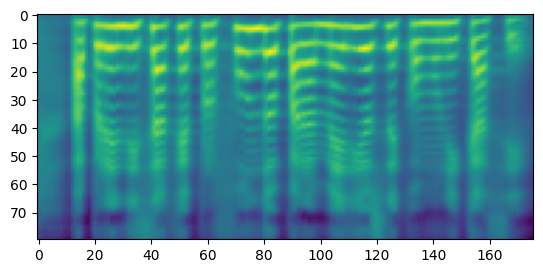

In [13]:
text = "aprendizaje profundo para medios de comunicación" #Deeplearning for Media in Spanish
speaker_embeddings = torch.load("SpeakerWoman2.pt")#Pick a speaker

inputs = processor(text=text, return_tensors="pt")
#spectrogram = model.generate_speech(inputs["input_ids"].to("cuda:0"), speaker_embeddings.to("cuda:0"))
spectrogram = model.generate_speech(inputs["input_ids"], speaker_embeddings)
#spectrogram_cpu = spectrogram.to("cpu")
plt.figure()
plt.imshow(spectrogram.T)
plt.show()

In [14]:
# Now let's listen...
with torch.no_grad():
    
    speech = vocoder(spectrogram)

from IPython.display import Audio

Audio(speech.numpy(), rate=16000)

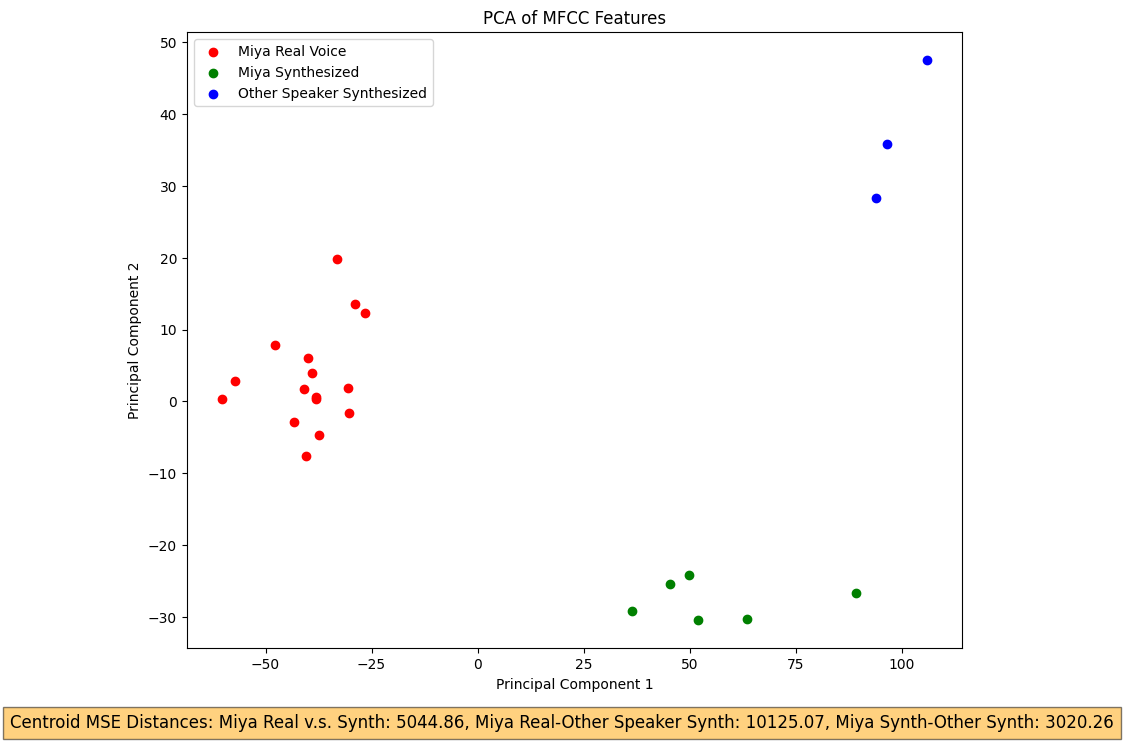

In [17]:
import librosa
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import os

def load_and_mfcc(filename, n_mfcc=12, sr=22050):
    audio, sr = librosa.load(filename, sr=sr)
    mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc)
    mfcc_mean = np.mean(mfcc, axis=1)
    return mfcc_mean

def process_audio_files(directory):
    filenames = [os.path.join(directory, f) for f in os.listdir(directory) if f.endswith('.wav')]
    real_files = [f for f in filenames if 't' in os.path.basename(f) and os.path.basename(f).startswith('t')]
    miya_files = [f for f in filenames if 'miyavoice_' in os.path.basename(f)]
    other_files = [f for f in filenames if 'output' in os.path.basename(f)]

    real_mfccs = np.array([load_and_mfcc(f) for f in real_files])
    miya_mfccs = np.array([load_and_mfcc(f) for f in miya_files])
    other_mfccs = np.array([load_and_mfcc(f) for f in other_files])

    return real_mfccs, miya_mfccs, other_mfccs

def perform_pca_and_plot(mfcc_data, real_len, miya_len, other_len):
    pca = PCA(n_components=2)
    pca_features = pca.fit_transform(mfcc_data)

    colors = ['red', 'green', 'blue']
    groups = ['Miya Real Voice', 'Miya Synthesized', 'Other Speaker Synthesized']

    plt.figure(figsize=(10, 8))
    plt.scatter(pca_features[:real_len, 0], pca_features[:real_len, 1], c=colors[0], label=groups[0])
    plt.scatter(pca_features[real_len:real_len+miya_len, 0], pca_features[real_len:real_len+miya_len, 1], c=colors[1], label=groups[1])
    plt.scatter(pca_features[-other_len:, 0], pca_features[-other_len:, 1], c=colors[2], label=groups[2])

    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.title('PCA of MFCC Features')
    plt.legend()

    # Calculate centroids and MSE
    centroid_real = np.mean(pca_features[:real_len], axis=0)
    centroid_miya = np.mean(pca_features[real_len:real_len+miya_len], axis=0)
    centroid_other = np.mean(pca_features[-other_len:], axis=0)

    mse_real_miya = np.mean((centroid_real - centroid_miya) ** 2)
    mse_real_other = np.mean((centroid_real - centroid_other) ** 2)
    mse_miya_other = np.mean((centroid_miya - centroid_other) ** 2)

    mse_text = f"Centroid MSE Distances: Miya Real v.s. Synth: {mse_real_miya:.2f}, Miya Real-Other Speaker Synth: {mse_real_other:.2f}, Miya Synth-Other Synth: {mse_miya_other:.2f}"
    plt.figtext(0.5, 0.01, mse_text, ha="center", fontsize=12, bbox={"facecolor":"orange", "alpha":0.5, "pad":5})

    plt.show()

def main():
    directory = 'content/'
    real_mfccs, miya_mfccs, other_mfccs = process_audio_files(directory)

    all_mfcc_data = np.vstack((real_mfccs, miya_mfccs, other_mfccs))
    perform_pca_and_plot(all_mfcc_data, len(real_mfccs), len(miya_mfccs), len(other_mfccs))

if __name__ == "__main__":
    main()
